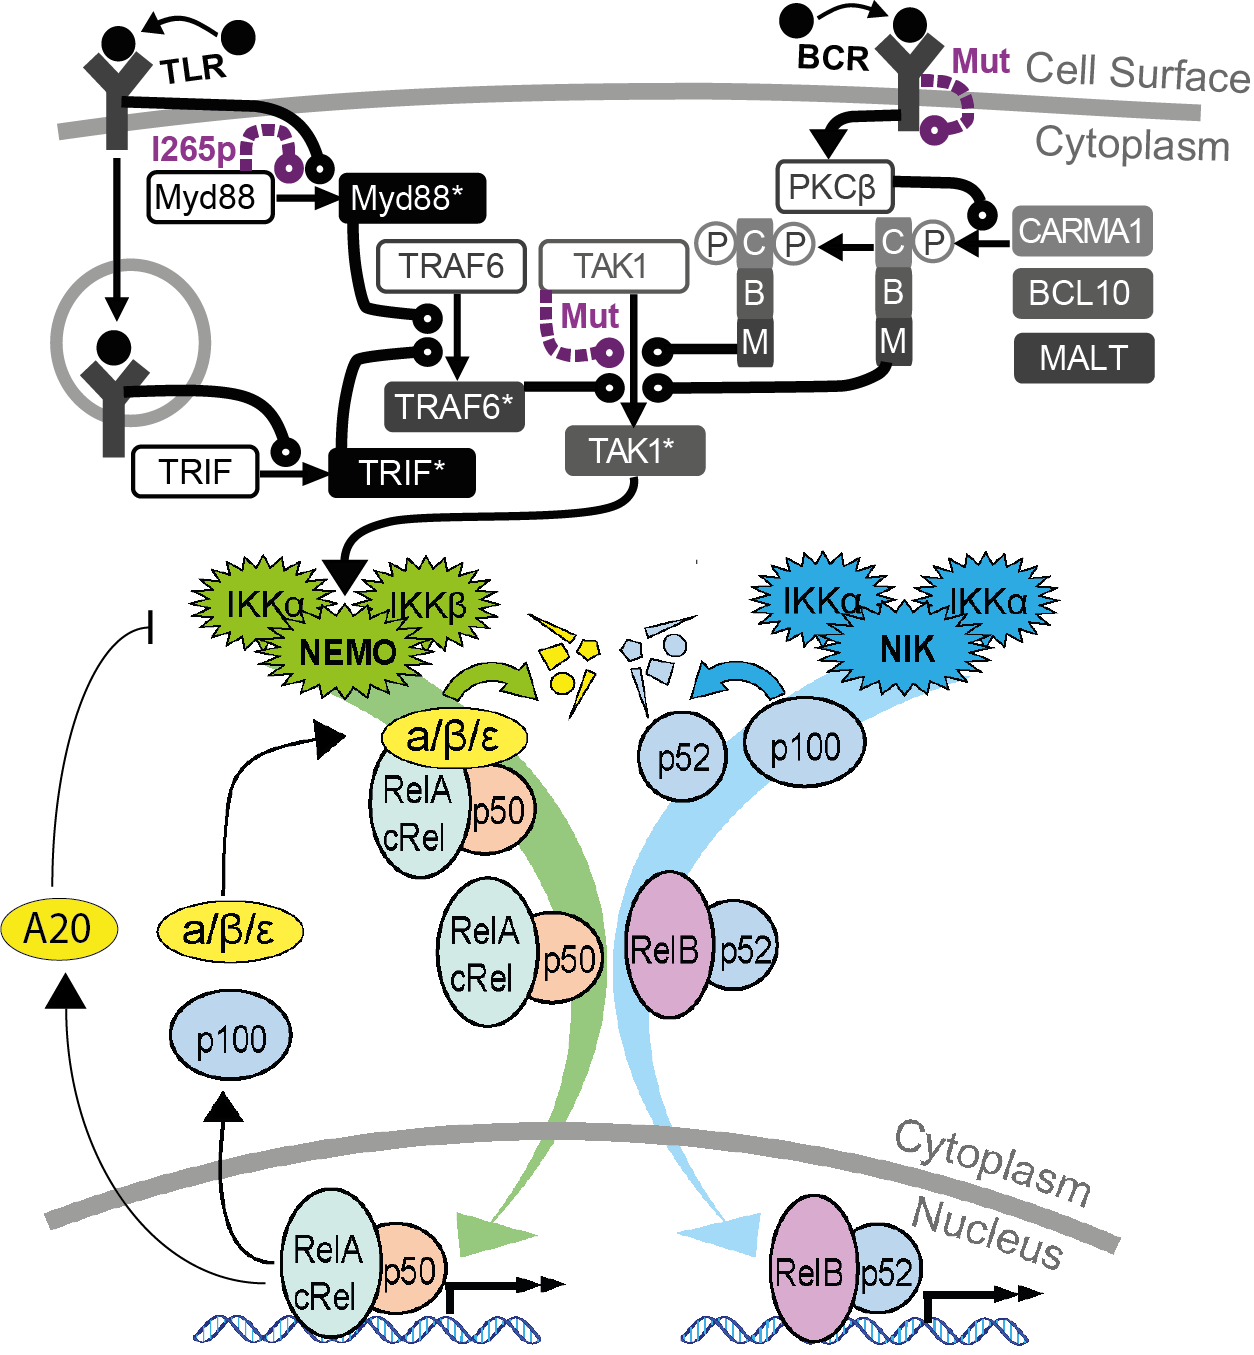

In [16]:
display("image/png", read("triModelA20Diagram.png"))

In [17]:
###########################################################################
### File locations  ######################################################
###########################################################################
### set up where CSV2Julia is
locationOfCSV2Julia="csv2Julia/csv2model-multiscale.py"
#we use the same initial conditions at the PNAS paper 2019 Mitchell Roy et al.
fullModelInitFile="initialConditions/fullModelInits.csv"
moduleDefinitionFilesFolder="moduleDefinitionFiles/"
locationOfFixSpexies="utilityFunctions/"

"utilityFunctions/"

In [18]:
#packages we need
using DifferentialEquations
using Plots 
using Pkg
# Pkg.add(Pkg.PackageSpec(;name="Parsers", version="2.2.4"))
using CSV
using Distributions
using Random
using DataFrames
using JLD2
using FileIO
using StatsPlots
using Plots.PlotMeasures
using Statistics

delay=false

false

In [19]:
function combineModels(modulesToInclude)
    ################################################
    ### Create a combined model from the modules ###
    ################################################
    #first lets tell Julia where the files are

    linkingModuleName="linking"
    combinedModelLocation="combinedModelDefinitionFiles/"
    mkpath(combinedModelLocation)


    #first lets load the linking file so we know to skip any reactions 
    #which are doubly described by the linking file and one of the modules
    linkingReactions=""
    if(delay)
        linkingReactions = DataFrame(CSV.File(moduleDefinitionFilesFolder*linkingModuleName*"/reactions_withDelay.csv",stringtype=String,types=String))
    else
        linkingReactions = DataFrame(CSV.File(moduleDefinitionFilesFolder*linkingModuleName*"/reactions.csv",stringtype=String,types=String))
    end
    linkingParameters = DataFrame(CSV.File(moduleDefinitionFilesFolder*linkingModuleName*"/parameters.csv",stringtype=String,types=String))
    linkingrateLaws = DataFrame(CSV.File(moduleDefinitionFilesFolder*linkingModuleName*"/rateLaws.csv",stringtype=String,types=String))

    #missing values mess things up so replace with empty strings
    replace!(linkingReactions.Substrate, missing => "")
    replace!(linkingReactions.Products, missing => "")

    #we know we need all the linking reactions in the combined model
    reactionsCombined=linkingReactions
    parametersCombined=linkingParameters
    linkingParameters[:,1]=linkingParameters[:,1].*("-"*"linking")
    theseParams=linkingReactions.Parameters
    replacementParams=""
    newParams=theseParams
    thisLine=1
    for param in theseParams
        if ismissing(param)
            thisLine=thisLine+1
        else
            eachParam=split(param," ")
            eachParam=[i*"-"*"linking" for i in eachParam]
            replacementParams=join(eachParam," ")
            newParams[thisLine]=replacementParams
            thisLine=thisLine+1
        end
    end
    linkingReactions.Parameters=newParams
    rateLawsCombined=linkingrateLaws

    # loop through each model
    for mod in modulesToInclude
        print("adding $(mod) module\n")

        thisModule=moduleDefinitionFilesFolder*mod
        #the NFkB file can have delays but the rest do not
        reactionFile=""
        if mod=="NFkB" && delay
            reactionFile=thisModule*"/reactions_withDelay.csv"
        else
            reactionFile=thisModule*"/reactions.csv"
        end
        parameterFile=thisModule*"/parameters.csv"
        rateLawsFile=thisModule*"/rateLaws.csv"

        parameterDF = CSV.read(parameterFile,DataFrame,stringtype=String,types=String)
        rateLawDF = CSV.read(rateLawsFile,DataFrame,stringtype=String,types=String)
        reactionDF = CSV.read(reactionFile,DataFrame,stringtype=String,types=String)
        #not every entry in the reaction database is filled in and missing data can cause a problem
        replace!(reactionDF.Substrate, missing => "")
        replace!(reactionDF.Products, missing => "")

        #keep track of rows to remove
        #these are rows that appear in individual module reaction files 
        #and are replaced by reactions in the linking module.
        rowsToRemove=[]
        thisRow=1
        for row in eachrow(reactionDF)
            if nrow(linkingReactions[(linkingReactions[!,"Substrate"].==row.Substrate).&(linkingReactions[!,"Products"].==row.Products),:])>0
                print("removing: $(row.Substrate) -> $(row.Products) as it is included in linking file\n")
                push!(rowsToRemove,thisRow)
            end
            thisRow=thisRow+1
        end
        delete!(reactionDF, rowsToRemove)
        print("adding module $(mod) to combined reaction array\n")

        #we need to append a module ID on each parameter name in the reactions file 
        #because some parameters have the same name in multiple modules
        theseParams=reactionDF.Parameters
        replacementParams=""
        newParams=theseParams
        thisLine=1
        for param in theseParams
            eachParam=split(param," ")
            eachParam=[i*"-"*mod for i in eachParam]
            replacementParams=join(eachParam," ")
            newParams[thisLine]=replacementParams
            thisLine=thisLine+1
        end
        reactionDF.Parameters=newParams
        append!(reactionsCombined,reactionDF)

        #do the same, prepending in the parameters file for the combined model
        parameterDF = CSV.read(parameterFile,DataFrame,stringtype=String,types=String)
        rowsToRemove=[]
        thisRow=1
        for row in eachrow(parameterDF)
            if nrow(linkingParameters[(linkingParameters[!,"parameter"].==row.parameter),:])>0
                print("removing: $(row.parameter) as it is included in linking file\n")
                push!(rowsToRemove,thisRow)
#             elseif occursin("p[",row.value)
#                 print("removing: $(row.parameter) as it includes p[t]\n")
#                 push!(rowsToRemove,thisRow)
            end

            thisRow=thisRow+1
        end
        delete!(parameterDF, rowsToRemove)

        theseParams=parameterDF.parameter
        parameterDF.parameter=parameterDF.parameter.*("-"*mod)

        append!(parametersCombined,parameterDF)

        #rate law duplication seems ok and unambiguous for now
        rateLawsDF=CSV.read(rateLawsFile,DataFrame;stringtype=String,types=String)
        append!(rateLawsCombined,rateLawsDF)

        print("finished $(mod)\n\n")
    end
    #write out the combined model
    CSV.write(combinedModelLocation*"reactions.csv", reactionsCombined)
    CSV.write(combinedModelLocation*"parameters.csv", parametersCombined)
    CSV.write(combinedModelLocation*"rateLaws.csv", rateLawsCombined)
    print("finished combining all modules\n")
    return combinedModelLocation
end

combineModels (generic function with 1 method)

In [20]:
using CSV

In [21]:
combinedModelLocation=combineModels(["BCR","TLR","NFkB","BCL2"])

adding BCR module
removing: TAK1 -> TAK1p as it is included in linking file
removing: TAK1 -> TAK1p as it is included in linking file
removing: TAK1 -> TAK1p as it is included in linking file
removing: TAK1 -> TAK1p as it is included in linking file
removing: TAK1 -> TAK1p as it is included in linking file
removing: TAK1 -> TAK1p as it is included in linking file
removing: TAK1p -> TAK1 as it is included in linking file
removing: TAK1C -> TAK1pC as it is included in linking file
removing: TAK1C -> TAK1pC as it is included in linking file
removing: TAK1C -> TAK1pC as it is included in linking file
removing: TAK1C -> TAK1pC as it is included in linking file
removing: TAK1C -> TAK1pC as it is included in linking file
removing: TAK1C -> TAK1pC as it is included in linking file
removing: TAK1C -> TAK1pC as it is included in linking file
removing: TAK1C -> TAK1pC as it is included in linking file
adding module BCR to combined reaction array
finished BCR

adding TLR module
removing: TAK1 -> T

"combinedModelDefinitionFiles/"

In [22]:
parametersFile=combinedModelLocation*"parameters.csv"
reactionsFile=combinedModelLocation*"reactions.csv"
rateLawsFile=combinedModelLocation*"rateLaws.csv"
parametersDF = DataFrame(CSV.File(parametersFile,types=Dict(:parameter=>String, :value=>String)))
originalParams=deepcopy(parametersDF)

thisModelName="odeModel.jl"
thisParamFile=parametersFile
arguments=[reactionsFile, thisParamFile, rateLawsFile,thisModelName]
cmd=`python3 $locationOfCSV2Julia $arguments param`

#lets run csv2julia (requires python to be installed)
run(cmd)

include(thisModelName)
mkpath("distributedModelFiles")
mv(thisModelName,"distributedModelFiles/"*thisModelName, force=true)
println("Model generated for all conditions")

param
Running CSV2JuliaDiffEq with parameters dynamically determined by a variable, re-run with the 5th argument set to 'scan' or 'inline'
Opening combinedModelDefinitionFiles/rateLaws.csv as rate law file
Opening combinedModelDefinitionFiles/parameters.csv as parameters file
Opening combinedModelDefinitionFiles/reactions.csv as reactions file
Model generated for all conditions


In [23]:
function inputFunc(t)
    if (t<600)
        return 0.01
    else
        return 0.01/(1+((t-20)/60))
    end
#    return maximum([1/(1+((t-10)*10)),0])
end

function inputFuncSS(t)
        return 0   
end
function inputFuncSSHigh(t)
        return 0.005    
end


function inputFuncHigh(t)
    if (t<1)
        return 0.001
    else
        return 0
    end

end
# function inputFuncSlowTLR(t)
#         TLRval=(t-500)/1000000
#         return TLRval
#     else
#         t=0
#     end

# end
function NIKinputFunc2(t)
# #     if (t>4*60)
# #         return 0.05
# #     else
# #         return 1
# #     end
#     return maximum([),0])
    return 1/(1+(t/600))
end
function NIKFuncSS(t)
    return 1
end

function NIKFuncSSHigh(t)
    return 0.9   
end




bcrSignalSS=inputFuncSS
bcrSignalSSHigh=inputFuncSSHigh
tlrSignalSS=inputFuncSS
bcrSignalTC=inputFunc
tlrSignalTC=inputFuncHigh
#tlrSignalTC=inputFuncSlowTLR
nikSignalSS=NIKFuncSS
nikSignalTC=NIKinputFunc2

NIKinputFunc2 (generic function with 1 method)

In [24]:
#fix the death ligand concentration
t=0
include("distributedModelFiles/odeModel.jl")
include("variableNames.jl")
include("scanIncludes.jl")

parameters can now be searched in parameterNameList by name.
example to modify k_binding 1.5 fold higher:
indexOfParam=findfirst(x->"k_binding"==x,parameterNameList)
paramVals[indexOfParam]=paramVals[indexOfParam]*1.5


In [25]:
include("runSimulation.jl")
include("plotAllSpecies.jl")
colorArray=palette(:seaborn_colorblind)

In [26]:
first_cell=1
last_cell=1
preCV=0.11
maxTimeTC=24*60
maxTimeSS=1000*60

60000

In [27]:
conditions=[]
paramsToChange=[]
modifyAmount=[]
BCRSSArray=[]
BCRTCArray=[]
TLRSSArray=[]
TLRTCArray=[]
NIKSSArray=[]
NIKTCArray=[]





# # RIVA
 push!(conditions,"RIVA")
 push!(paramsToChange,["k1_MYD88SELFACTIVATION-TLR","k1_IkBdRelA50Ass-NFkB","basal_RelBSynth-NFkB",
        "basal_cRelSynth-NFkB","k1_Mcl1exp-BCL2","k1_BclxLexp-BCL2","k1_Bcl2exp-BCL2"])
 push!(modifyAmount,[0.0,0.1,1.5,1,3,4,4])
 push!(BCRSSArray,bcrSignalSS)
 push!(BCRTCArray,bcrSignalSS)
 push!(TLRSSArray,tlrSignalSS)
 push!(TLRTCArray,tlrSignalSS)
 push!(NIKSSArray,nikSignalSS)
 push!(NIKTCArray,nikSignalSS)








println("Summary of conditions being run:")
folder="teachingOutputs"
show(IOContext(stdout, :limit => false), "text/plain", hcat(conditions,paramsToChange,modifyAmount))



Summary of conditions being run:
1×3 Matrix{Any}:
 "RIVA"  ["k1_MYD88SELFACTIVATION-TLR", "k1_IkBdRelA50Ass-NFkB", "basal_RelBSynth-NFkB", "basal_cRelSynth-NFkB", "k1_Mcl1exp-BCL2", "k1_BclxLexp-BCL2", "k1_Bcl2exp-BCL2"]  [0.0, 0.1, 1.5, 1.0, 3.0, 4.0, 4.0]

In [28]:
runSimulation(first_cell,last_cell,conditions,folder,BCRSSArray,BCRTCArray,TLRSSArray,TLRTCArray,NIKSSArray,NIKTCArray)

parameters can now be searched in parameterNameList by name.
example to modify k_binding 1.5 fold higher:
indexOfParam=findfirst(x->"k_binding"==x,parameterNameList)
paramVals[indexOfParam]=paramVals[indexOfParam]*1.5
Starting condition: RIVA
starting cell: 1
Steady state found for cell: 1
Solving equations for dynamic time course for cell:1
all cells done in condition: RIVA


In [29]:
hoursToPlot=24
colorArray=palette(:seaborn_colorblind)[[1,2,3,4,5]]
speciesToPlot=syms
maxValOfYAxis=50
conditions=conditions[[1]]
speciesToPlot=["RelAnp50n","RelBnp52n","cRelnp50n"]
qualityScaling=0.5
plotly()
#let't plot!
plotAllSpecies(speciesToPlot,conditions,colorArray,first_cell,last_cell,folder,hoursToPlot,maxValOfYAxis,qualityScaling,60);

## hoursToPlot=18
colorArray=palette(:seaborn_colorblind)[[1,2,3,4]]
speciesToPlot=syms
maxValOfYAxis=10
conditions=conditions[[1,2,3,4]]
#speciesToPlot=["RelAnp50n","cRelnp50n","RelBnp52n","Bcl2","Mcl1","BclxL"]
#speciesToPlot=["Bcl2","Mcl1","BclxL","RelA*","RelB*","cRel*","RelAnp50n","RelBnp52n","cRelnp50n","p100*","p50*"]
speciesToPlot=["Mcl1","Bcl2","BclxL"]
qualityScaling=0.5
plotly()
#let't plot!
plotAllSpecies(speciesToPlot,conditions,colorArray,first_cell,last_cell,folder,hoursToPlot,maxValOfYAxis,qualityScaling,60);

In [15]:
hoursToPlot=24
colorArray=palette(:seaborn_colorblind)[[1,2,3,4,5]]
speciesToPlot=syms
maxValOfYAxis=10
conditions=conditions[[1]]
speciesToPlot=["Mcl1","Bcl2","BclxL"]
qualityScaling=0.5
plotly()
#let't plot!
plotAllSpecies(speciesToPlot,conditions,colorArray,first_cell,last_cell,folder,hoursToPlot,maxValOfYAxis,qualityScaling,60);